### Import Package

In [ ]:
import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

### Setup a Device

In [ ]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Hyperparameters

In [ ]:
# 하이퍼파라미터

num_epochs = 100
num_classes = 7
batch_size = 16
learning_rate = 0.001

### Load Dataset

In [ ]:
# Training을 위한 데이터 확장과 데이터셋 정규화

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),  # 랜덤 리사이즈 후 크롭
        transforms.RandomHorizontalFlip(),  # 좌우반전
        transforms.RandomRotation(30),       # 랜덤 회전 (degree) 
        transforms.ColorJitter(0.1,0.1,0.1), # 컬러 변화
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test를 위해서는 데이터셋 정규화만

test_transforms = transforms.Compose([
        transforms.Resize(256),             # 리사이즈
        transforms.CenterCrop(224),         # 가운데 크롭
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
# ImageFolder를 사용하여 폴더 안에 있는 이미지들을 데이터셋으로 사용

train_dataset = datasets.ImageFolder( './dataset/train', train_transforms)
test_dataset = datasets.ImageFolder( './dataset/test', test_transforms)

train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True )

# 분류 클래스 7개: avante, genesis_sedan, genesis_suv, grandeur, palisade, santafe, sonata

class_names = train_dataset.classes
print(class_names)

['avante', 'genesis_sedan', 'genesis_suv', 'grandeur', 'palisade', 'santafe', 'sonata']


### Preview Data

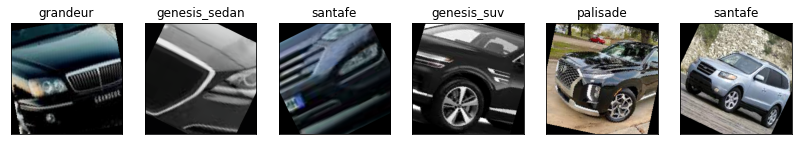

In [ ]:
def convert_to_imshow_format(image):
    # from 3 x Height x Width to Height x Width x 3
    image = image.numpy().transpose(1,2,0)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # convert back to [0,1] range from [-1,1] range
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    return image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images[:6], labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(14,4))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(class_names[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress Monitor

In [ ]:
from IPython.display import HTML, display

# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Epoch: {epoch}/{num_epochs} Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0, 0, 0), display_id=True)
        
    def html(self, count, loss, epoch, num_epochs):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss, epoch=epoch, num_epochs=num_epochs))
        
    def update(self, epoch, num_epochs, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss, epoch, num_epochs))

### Finetuning the Convnet

In [ ]:
# ConvEnsemble 클래스

class ConvEnsemble(nn.Module):
    def __init__(self):
        super().__init__()

        self.model_a = models.resnet50(pretrained=True)
        self.model_b = models.densenet121(pretrained=True)
        # self.model_c = models.densenet121(pretrained=True)

        self.fc = nn.Linear(2000, num_classes ) # Edit (FC layer 입력을 3000으로)

    def forward(self, x):
        out_a = self.model_a(x)
        out_b = self.model_b(x)
        # out_c = self.model_c(x)
        # Edit (out_c)

        # out_a의 모양은 (N, 1000)
        # out_b의 모양은 (N, 1000)
        # out_s의 모양은 (N, 2000), 옆으로 길게 이어붙이는 concaternation (연접)
        # 만약 모델 3개를 이어붙인다면 out_s의 모양은 (N, 3000)

        out_s = torch.cat( (out_a, out_b), dim=1 )  # Edit (out_a, out_b, out_c)
 
        out = self.fc(out_s)

        return out

In [ ]:
# 앙상블 모델을 선택

# model = models.resnet18(pretrained=True)
# model = models.resnet50(pretrained=True)
# model = models.vgg19(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.densenet121(pretrained=True)

model = ConvEnsemble()

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date w

  0%|          | 0.00/30.8M [00:00<?, ?B/s]

ConvEnsemble(
  (model_a): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
# 가중치 학습되지 않도록 전부 고정***
# for param in model.parameters():
#     param.requires_grad = False

# 마지막 fc layer 새로 만들어 out_features를 2로 변경
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# GPU로 모델 전송
model = model.to(device)

# 손실함수
loss_func = nn.CrossEntropyLoss()

# 최적화 SGD 사용
# optimizer_ft = optim.SGD( model.parameters(), lr=learning_rate, momentum=0.9 )
# optimizer_ft = optim.Adam( model.parameters(), lr=learning_rate )
optimizer_ft = optim.Adagrad( model.parameters(), lr=learning_rate )
# optimizer_ft = optim.AdamW( model.parameters(), lr=learning_rate )
# optimizer_ft = optim.NAdam( model.parameters(), lr=learning_rate )

# LR Scheduler 사용
# 매 7 epoch 마다 기존 학습률에 0.1을 곱해주는 방식으로 학습률이 점점 작아지게
lr_scheduler_ft = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

### Train / Test

In [ ]:
# Train
def train(epoch, num_epochs, model, optimizer, scheduler):

    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(epoch, num_epochs, batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

    # 스케쥴러의 스텝을 증가 - 때가 되면 학습률 변경
    if scheduler:
        scheduler.step()

# Test
def test(model):
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test Acc: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  
    
    return acc

In [ ]:
since = time.time()

# initialize the best weights
best_model_weights = copy.deepcopy( model.state_dict() )
best_acc = 0.0

for epoch in range(num_epochs):

    # train
    train(epoch+1, num_epochs, model, optimizer_ft, lr_scheduler_ft )
    # test
    acc = test(model)

    # update the best weights
    if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy( model.state_dict() )
  
# load the best weights
model.load_state_dict( best_model_weights )

# summary
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best test accuracy: {:4f}'.format(best_acc))

Epoch: 1/100 Loss: 1.9814 1380 / 1380,1380


Test Acc: 292/462 (63.20%)


Epoch: 2/100 Loss: 1.2416 1380 / 1380,1380


Test Acc: 255/462 (55.19%)


Epoch: 3/100 Loss: 1.0665 1380 / 1380,1380


Test Acc: 300/462 (64.94%)


Epoch: 4/100 Loss: 0.9267 1380 / 1380,1380


Test Acc: 311/462 (67.32%)


Epoch: 5/100 Loss: 0.8078 1380 / 1380,1380


Test Acc: 360/462 (77.92%)


Epoch: 6/100 Loss: 0.7940 1380 / 1380,1380


Test Acc: 367/462 (79.44%)


Epoch: 7/100 Loss: 0.7259 1380 / 1380,1380


Test Acc: 372/462 (80.52%)


Epoch: 8/100 Loss: 0.6775 1380 / 1380,1380


Test Acc: 384/462 (83.12%)


Epoch: 9/100 Loss: 0.6215 1380 / 1380,1380


Test Acc: 382/462 (82.68%)


Epoch: 10/100 Loss: 0.6155 1380 / 1380,1380


Test Acc: 386/462 (83.55%)


Epoch: 11/100 Loss: 0.5618 1380 / 1380,1380


Test Acc: 398/462 (86.15%)


Epoch: 12/100 Loss: 0.5493 1380 / 1380,1380


Test Acc: 395/462 (85.50%)


Epoch: 13/100 Loss: 0.5270 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 14/100 Loss: 0.5111 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 15/100 Loss: 0.5052 1380 / 1380,1380


Test Acc: 398/462 (86.15%)


Epoch: 16/100 Loss: 0.4902 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 17/100 Loss: 0.5139 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 18/100 Loss: 0.4967 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 19/100 Loss: 0.4769 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 20/100 Loss: 0.4437 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 21/100 Loss: 0.4993 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 22/100 Loss: 0.4531 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 23/100 Loss: 0.4800 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 24/100 Loss: 0.4864 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 25/100 Loss: 0.5141 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 26/100 Loss: 0.4838 1380 / 1380,1380


Test Acc: 397/462 (85.93%)


Epoch: 27/100 Loss: 0.4963 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 28/100 Loss: 0.4705 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 29/100 Loss: 0.4756 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 30/100 Loss: 0.4730 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 31/100 Loss: 0.4446 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 32/100 Loss: 0.4784 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 33/100 Loss: 0.4934 1380 / 1380,1380


Test Acc: 399/462 (86.36%)


Epoch: 34/100 Loss: 0.4863 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 35/100 Loss: 0.5038 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 36/100 Loss: 0.4621 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 37/100 Loss: 0.4804 1380 / 1380,1380


Test Acc: 399/462 (86.36%)


Epoch: 38/100 Loss: 0.4690 1380 / 1380,1380


Test Acc: 408/462 (88.31%)


Epoch: 39/100 Loss: 0.4904 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 40/100 Loss: 0.4895 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 41/100 Loss: 0.4663 1380 / 1380,1380


Test Acc: 408/462 (88.31%)


Epoch: 42/100 Loss: 0.4826 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 43/100 Loss: 0.4875 1380 / 1380,1380


Test Acc: 407/462 (88.10%)


Epoch: 44/100 Loss: 0.4504 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 45/100 Loss: 0.4562 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 46/100 Loss: 0.4653 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 47/100 Loss: 0.4897 1380 / 1380,1380


Test Acc: 399/462 (86.36%)


Epoch: 48/100 Loss: 0.4741 1380 / 1380,1380


Test Acc: 399/462 (86.36%)


Epoch: 49/100 Loss: 0.4617 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 50/100 Loss: 0.4799 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 51/100 Loss: 0.4910 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 52/100 Loss: 0.4342 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 53/100 Loss: 0.4983 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 54/100 Loss: 0.4635 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 55/100 Loss: 0.4870 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 56/100 Loss: 0.4442 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 57/100 Loss: 0.5117 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 58/100 Loss: 0.4727 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 59/100 Loss: 0.4685 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 60/100 Loss: 0.4852 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 61/100 Loss: 0.4950 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 62/100 Loss: 0.4985 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 63/100 Loss: 0.4522 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 64/100 Loss: 0.5145 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 65/100 Loss: 0.4866 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 66/100 Loss: 0.4658 1380 / 1380,1380


Test Acc: 399/462 (86.36%)


Epoch: 67/100 Loss: 0.4988 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 68/100 Loss: 0.4937 1380 / 1380,1380


Test Acc: 398/462 (86.15%)


Epoch: 69/100 Loss: 0.4647 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 70/100 Loss: 0.4993 1380 / 1380,1380


Test Acc: 407/462 (88.10%)


Epoch: 71/100 Loss: 0.4827 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 72/100 Loss: 0.4886 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 73/100 Loss: 0.4694 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 74/100 Loss: 0.4580 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 75/100 Loss: 0.4959 1380 / 1380,1380


Test Acc: 406/462 (87.88%)


Epoch: 76/100 Loss: 0.4741 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 77/100 Loss: 0.5010 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 78/100 Loss: 0.4544 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 79/100 Loss: 0.4450 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 80/100 Loss: 0.4814 1380 / 1380,1380


Test Acc: 403/462 (87.23%)


Epoch: 81/100 Loss: 0.4806 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 82/100 Loss: 0.4787 1380 / 1380,1380


Test Acc: 396/462 (85.71%)


Epoch: 83/100 Loss: 0.4641 1380 / 1380,1380


Test Acc: 402/462 (87.01%)


Epoch: 84/100 Loss: 0.4781 1380 / 1380,1380


Test Acc: 407/462 (88.10%)


Epoch: 85/100 Loss: 0.5111 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 86/100 Loss: 0.4940 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 87/100 Loss: 0.4690 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 88/100 Loss: 0.4639 1380 / 1380,1380


Test Acc: 408/462 (88.31%)


Epoch: 89/100 Loss: 0.4920 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 90/100 Loss: 0.4542 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 91/100 Loss: 0.4822 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 92/100 Loss: 0.4688 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 93/100 Loss: 0.4762 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 94/100 Loss: 0.4613 1380 / 1380,1380


Test Acc: 396/462 (85.71%)


Epoch: 95/100 Loss: 0.4754 1380 / 1380,1380


Test Acc: 405/462 (87.66%)


Epoch: 96/100 Loss: 0.4824 1380 / 1380,1380


Test Acc: 401/462 (86.80%)


Epoch: 97/100 Loss: 0.4597 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 98/100 Loss: 0.4673 1380 / 1380,1380


Test Acc: 400/462 (86.58%)


Epoch: 99/100 Loss: 0.4797 1380 / 1380,1380


Test Acc: 404/462 (87.45%)


Epoch: 100/100 Loss: 0.4645 1380 / 1380,1380


Test Acc: 405/462 (87.66%)
Training completed in 73m 13s
Best test accuracy: 88.311688


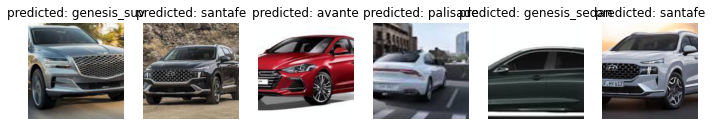

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.imshow( convert_to_imshow_format(inputs.cpu().data[j]) )

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model) 